# Quantum Approximate Optimization Algorithm 

We demonstrate how to implement QAOA using Pauli Propagation. Specifically, we solve the Max-Cut problem for two graphs, first a smaller graph and then for a large graph with IBM's heavy-hex lattice topology.

<div align="center">
    <img width=300 src=https://upload.wikimedia.org/wikipedia/commons/thumb/c/cf/Max-cut.svg/1280px-Max-cut.svg.png alt='max cut exmaple'/>
</div>
Max cut example on 5 nodes. Image from Wikipedia

## Requirements

The notebooks uses the libraries which can be installed using:

* `Pkg.add("Graphs")` to create graphs.
* `Pkg.add("GraphRecipes")` and `Pkg.add("Plots")` for visualizng graphs and plots.
* `Pkg.add("JuMP")` and `Pkg.add("SCIP")` to solve problem classically.
* `Pkg.add("Optim")` for optimizing circuit.

## Background Max-Cut

Given a graph $G = (V,E)$, the goal of max-cut is partition the vertices into two disjoint sets such that the number of edges between them is maximzed i.e. the goal is to maximize the number of cut edges.

$$
\max_{x\in \{0, 1\}^n} \sum_{(i,j) \in E} x_i + x_j - 2 x_i x_j,
$$

where $x_i$ and $x_j$ are binary variables for vertex $i$ and $j$. This represents a Quadratic Unconstrained Binary Optimization (QUBO) problem which, in matrix notation can be written as

$$
\max_{x\in \{0, 1\}^n}x^T Q x,
$$

where $Q$ is $n \times n$ matrix and $x$ is a binary vector of size n.

## QAOA with small graph

We start with a small graph that is shown above.

In [1]:
using Pkg
Pkg.instantiate()

In [2]:
using PauliPropagation
using Graphs
using GraphRecipes, Plots
using JuMP, SCIP
using Random
using ForwardDiff: gradient
using Base.Threads

using Optim
using LinearAlgebra

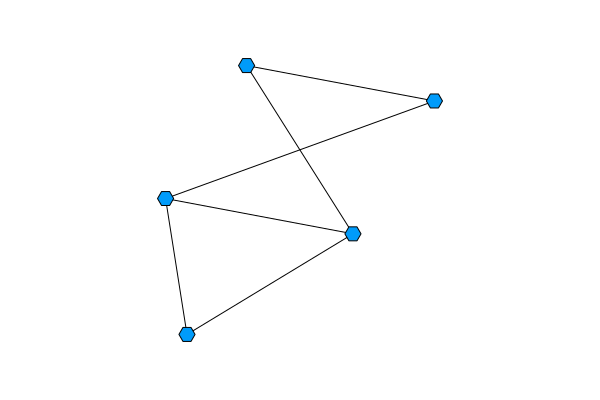

In [3]:
n = 5
edgelist = [(1, 2), (1, 3), (1, 5), (2, 3), (3, 4), (4, 5)]

graph = Graphs.SimpleGraph(n)
for (u, v) in edgelist
    Graphs.add_edge!(graph, u, v)
end

graphplot(graph, curves=false)

In [4]:
function max_cut_objective(g, x)
    cut_sum = 0 
    for edge in edges(g)
        i, j = (Graphs.src(edge), Graphs.dst(edge))
        cut_sum += (x[i] + x[j] - 2 * x[i] * x[j])
    end
    return cut_sum
end

# solve classically
function classical_maxcut_solver(g)
    model = Model(SCIP.Optimizer)
    set_attribute(model, "display/verblevel", 0)
    @variable(model, x[1:nv(g)], Bin)
    
    # Objective function (Max-Cut formulation)
    cut_sum = max_cut_objective(g, x)
    
    # Set the objective function (maximize cut weight)
    @objective(model, Max, cut_sum);

    optimize!(model)
    bitstring = value.(x)
    max_cut_value = objective_value(model)

    return bitstring, max_cut_value
    
end

classical_maxcut_solver (generic function with 1 method)

In [5]:
runtime = @elapsed bitstring, max_cut_value = classical_maxcut_solver(graph)
println("Runtime: $runtime seconds")

Runtime: 6.295607217 seconds


In [6]:
max_cut_value, Int.(bitstring)

(5.0, [0, 0, 1, 0, 1])

### Hamiltonian construction

We need to convert the objective function of the graph to Hamiltonian in order to use it with QAOA. To reformulate the QAOA problem to Hamiltonian, we can replace $x_i$ by and operator $X_i$ which is expressed in terms of Pauli-Z operator $Z_i$

$$
X_i = \frac{I-Z_i}{2}
$$

$X_i$ is diagonal with respect to computational basis and its eigenvalues are $0, 1$. Then the Hamiltonain can be written as

$$
\frac{1}{2} \sum_{(i,j)} \big(2I - Z_i - Z_j - (I - Z_i)(I - Z_j)\big) = \frac{1}{2}|E| - \frac{1}{2} \sum_{(i, j)} Z_i Z_j.
$$

In the last equation, $|E|$ denotes the number of edges in the graph. Usually we minimize a function (eg. finding ground state of the Hamiltonian) so we flip the sign and write the cost Hamiltonian as 

$$
H_c = \frac{1}{2} \sum_{(i, j)} Z_i Z_j - \frac{1}{2}|E|
$$

In [7]:
# construct hamiltonian
function construct_cost_hamiltonian(g)
    n_edges = ne(g)
    n_nodes = nv(g)
    opsum = PauliSum(n_nodes)
    add!(opsum, repeat([:I], n_nodes), collect(1:n_nodes), -n_edges/2)
    for edge in edges(g)
        pair = (Graphs.src(edge), Graphs.dst(edge))
        add!(opsum, [:Z, :Z], collect(pair), 0.5)
    end
    return opsum
end

construct_cost_hamiltonian (generic function with 1 method)

In [8]:
opsum = construct_cost_hamiltonian(graph)
opsum

PauliSum(nqubits: 5, 7 Pauli terms:
 -3.0 * IIIII
 0.5 * ZIZII
 0.5 * ZZIII
 0.5 * IZZII
 0.5 * IIZZI
 0.5 * ZIIIZ
 0.5 * IIIZZ
)

### Circuit Construction

The idea of QAOA is to start from the ground state of a known Hamiltonian $H^{\otimes n}|0\rangle$ and then slowly evolve the system into the ground state of the cost hamiltonian. In practice, this is achieved by applying the operators $\exp(-i\gamma_k H_C)$ and $\exp(-i\beta_k) H_m$. The QAOA circuit will be parameterised by $\gamma_i$ and $\beta_i$, and the goal is to find optimum value of these parameters.

<div align='center'>
    <img src="qaoa_circuit.png" width="800"/>
</div>

In [9]:
# construct the circuit
function construct_qaoa_circuit(g, p = 2)
    circuit::Vector{Gate} = []
    edgelist = [(Graphs.src(edge), Graphs.dst(edge)) for edge in edges(g)]
    for i in 1:p
        rzzlayer!(circuit, edgelist)
        rxlayer!(circuit, n)
    end
    return circuit
end

construct_qaoa_circuit (generic function with 2 methods)

In [10]:
p = 2
circuit = construct_qaoa_circuit(graph, p)
countparameters(circuit)

22

The parameters in QAOA circuit with $p$ layers are $\gamma_1,...,\gamma_p$ and $\beta_1,...,\beta_p~$. So with $p=$, we have $4$ parameters $\gamma_1,\gamma_2$ and $\beta_1, \beta_2~$. However, here we see $22$ parameters because `PauliPropagation` assigns each gate an independent parameters so it has $p(|E| + |V|)$ parameters i.e. $2(6 + 5) = 22$. We will see below a workaround for this.

### Circuit Optimization

We need to final the optmial parameters $\gamma_i$ and $\beta_i$ by iterative optimization loop. We first start with random initial values of the parameters and iteratively optimize them using a classical optimizer.

#### Initial Parameters

We randomly choose $2p$ initial parameters.

In [11]:
Random.seed!(42)
x0 = rand(-π:0.01:π, 2 * p)

4-element Vector{Float64}:
  0.8084073464102071
 -0.31159265358979304
 -0.14159265358979312
  1.2784073464102068

The below function handles assignment of parameters to quantum circuit. Given list of `params` which is of the following format

$$
$\gamma_1, \beta_1, \gamma_2, \beta_2...,\gamma_p, \beta_p$
$$

It expands the `params` array by repeating each $\gamma_i$ $|E|$ times and $\beta_i$ $|V|$ times which results into the following array.

$$
\underbrace{\gamma_1, ..., \gamma_1}_{\text{$|E|$ times}}, \underbrace{\beta_1,...,\beta_1}_{\text{$|V|$ times}}, ... , \underbrace{\gamma_p, ..., \gamma_p}_{\text{$|E|$ times}}, \underbrace{\beta_p,...,\beta_p}_{\text{$|V|$ times}}
$$

In [12]:
function expand_params(params::AbstractVector{T}, n_edges::Int, n_qubits::Int) where T
    # Extract gammas and betas
    # @view avoids copies and plays nicely with AD
    gammas = @view params[1:2:end]  # Select every other column starting from the first column
    betas = @view params[2:2:end]   # Select every other column starting from the second column

    # Repeat gammas and betas
    gamma_expanded = repeat(gammas, 1, n_edges)  # Repeat along the third dimension (n_edges)
    beta_expanded = repeat(betas, 1, n_qubits)  # Repeat along the third dimension (n_qubits)

    # Concatenate gammas and betas along the third dimension
    expanded_layers = hcat(gamma_expanded, beta_expanded)
    expanded_params = reshape(expanded_layers', :)

    return expanded_params
end

expand_params (generic function with 1 method)

Lets see with a dummy array

In [13]:
params = float.(collect(1:4))
print(expand_params(params, length(edgelist), n))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0]

In [14]:
# create a functor (callable struct)
struct CostFunction{A,H,G,T}
    ansatz::A
    H::H
    g::G
    min_abs_coeff::T
    max_weight::T
end

function (cf::CostFunction)(params::AbstractVector{T}) where {T}
    # Expand parameters
    expanded = expand_params(params, ne(cf.g), nv(cf.g))

    # Pre-convert Hamiltonian to AD-compatible coefficient type
    grad_ready_H = convertcoefftype(T, cf.H)

    psum = propagate(cf.ansatz, grad_ready_H, 2 * expanded;
                     min_abs_coeff = cf.min_abs_coeff,
                     max_weight    = cf.max_weight)

    return overlapwithzero(psum)
    # If i optimize using Overlapwithplus
    # i am unable to recover the bitstring
end

In [15]:
# n_expanded_params = Int(countparameters(circuit))

min_abs_coeff = 1e-3
max_weight = float.(n)
# max_weight = Inf
cost = CostFunction(
    circuit,
    opsum,
    graph,
    min_abs_coeff,
    max_weight,
    # n_expanded_params
)

@time cost(x0)

  1.201888 seconds (2.48 M allocations: 120.847 MiB, 99.98% compilation time)


-2.365172731218447

In [16]:
# gradients
@time gradient(cost, x0)

  1.806304 seconds (6.69 M allocations: 323.156 MiB, 3.48% gc time, 99.98% compilation time)


4-element Vector{Float64}:
  0.0
  3.9001460738220333
 -3.4570852696040624
  3.7667856665993007

In [17]:
function grad!(G, x)
    G .= gradient(cost, x)
end

grad! (generic function with 1 method)

In [18]:
# function callback(obj)
#     push!(objective_func_vals, obj.f_x)
#     false
# end

# Callback using let block
function get_callback()
    objective_func_vals = Float64[] # Global variable
    cb = let vals = objective_func_vals
        (state) -> begin
            push!(vals, state.f_x)
            false  # continue optimization
        end
    end
    return cb, objective_func_vals
end

get_callback (generic function with 1 method)

In [19]:
cb,  objective_func_vals=  get_callback()
options = Optim.Options(callback=cb, iterations=10, show_trace=true)

runtime = @elapsed res = optimize(cost, grad!, x0, LBFGS(), options)

Iter     Function value   Gradient norm 
     0    -2.365173e+00     3.900146e+00
 * time: 0.020406007766723633
     1    -3.868397e+00     1.566003e+00
 * time: 0.9900059700012207
     2    -3.998854e+00     1.274339e-01
 * time: 0.990811824798584
     3    -3.999563e+00     6.502197e-02
 * time: 0.9910719394683838
     4    -3.999998e+00     6.177928e-03
 * time: 0.9912469387054443
     5    -4.000000e+00     9.835865e-07
 * time: 0.9913330078125
     6    -4.000000e+00     3.063082e-12
 * time: 0.9914138317108154


1.974958232

In [20]:
res

 * Status: success

 * Candidate solution
    Final objective value:     -4.000000e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.23e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.22e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.79e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.20e-14 ≰ 0.0e+00
    |g(x)|                 = 3.06e-12 ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    6
    f(x) calls:    18
    ∇f(x) calls:   18
    ∇f(x)ᵀv calls: 0


In [21]:
opt_params = Optim.minimizer(res)
opt_value = Optim.minimum(res)

println("Final overlap: ", opt_value)
println("Best parameters: ", opt_params)
println("Runtime: $runtime seconds")

Final overlap: -4.0
Best parameters: [0.8084073464102071, -2.356194490192129, 1.5707963267951293, -0.7853981633978312]
Runtime: 1.974958232 seconds


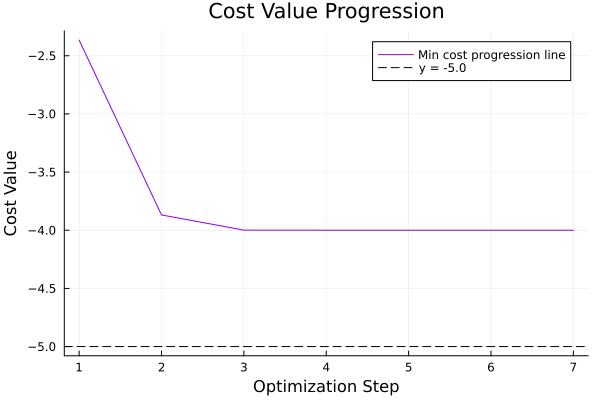

In [22]:
x_vals = 1:length(objective_func_vals)
p1 = plot(x_vals, objective_func_vals, label="Min cost progression line", linecolor="#8d00e7")
hline!(p1, [-max_cut_value], linestyle=:dash, color=:black, label="y = -$(max_cut_value)") # Add horizontal line
xlabel!(p1, "Optimization Step")
ylabel!(p1, "Cost Value")
title!(p1, "Cost Value Progression")
display(p1)

### Recover Bitstring

For a variational state $|\psi\rangle = U(\boldsymbol{\theta})|+\rangle$, the probability of observing a computational-basis bitstring $|b\rangle$ is

$$
P(b) = \langle \psi | \Pi_b | \psi \rangle,
\qquad \Pi_b = |b\rangle\langle b|.
$$

Each projector factorizes as

$$
\Pi_b = \bigotimes_i \frac{I + (-1)^{b_i} Z_i}{2}.
$$

If the output distribution is sharply peaked around a bitstring $\mathbf{x}$, then each qubit exhibits a strong marginal bias toward $x_i$. The single-qubit marginals are

$$
P(x_i = 0) = \frac{1 + \langle Z_i \rangle}{2}, \qquad
P(x_i = 1) = \frac{1 - \langle Z_i \rangle}{2}.
$$

Thus, the dominant bitstring can be inferred directly from the signs of the Pauli-(Z) expectation values:

$$
\langle Z_i \rangle > 0 \Rightarrow x_i = 0, \quad
\langle Z_i \rangle < 0 \Rightarrow x_i = 1
$$

In [23]:
struct ExpectationEngine{A,G,T}
    ansatz::A
    g::G
    params::Vector{T}
    min_abs_coeff::T
    max_weight::T
end

function (eng::ExpectationEngine)(observables::Vector{<:PauliString})
    # Expand the stored parameters once
    expanded = expand_params(eng.params, ne(eng.g), nv(eng.g))
    
    evs = zeros(length(observables))

    @threads for i in eachindex(observables)
        psum = propagate(
            eng.ansatz, 
            observables[i], 
            2 * expanded,
            min_abs_coeff = eng.min_abs_coeff,
            max_weight = eng.max_weight
        )
        evs[i] = overlapwithzero(psum)
        # If the circuit was optimized using Overlapwithplus
        # then i think i should use here also Overlapwithplus
        # but then i am unable to recover the bitstring
    end

    return evs
end

In [24]:
obs = [PauliString(n, :Z, i) for i in 1:n]  # single-qubit Zs

engine = ExpectationEngine(circuit, graph, opt_params, min_abs_coeff, max_weight)
expvals = engine(obs)
bitstring = [ev > 0 ? 0 : 1 for ev in expvals]

max_cut_objective(graph, reverse(bitstring)), max_cut_objective(graph, bitstring), bitstring
# Why reverse gives better objective value? lucky?

(5, 4, [1, 0, 1, 0, 0])

## QAOA on IBM's heavy-hex lattice

Let's scale the problem to a 127 qubits with topology of IBM's heavy-hex lattice. 

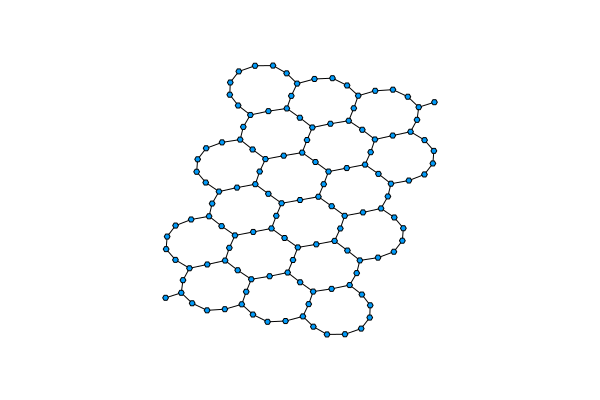

In [25]:
n = 127
graph_hex = SimpleGraph(n)
for (u, v) in ibmeagletopology
    Graphs.add_edge!(graph_hex, u, v)
end

graphplot(graph_hex, curves=false)

### Solve classically

In [26]:
runtime = @elapsed bitstring, max_cut_value = classical_maxcut_solver(graph_hex)
println("Runtime: $runtime seconds")
max_cut_value

Runtime: 0.018297782 seconds


144.0

### Hamiltonian Construction

In [27]:
opsum_hex = construct_cost_hamiltonian(graph_hex)
opsum_hex
# can symmetry merging help reducing pauli terms? 

PauliSum(nqubits: 127, 145 Pauli terms:
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IZZIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
 0.5 * IIIIIIIIIIIIIIIIIIII...
  ⋮)

### Circuit Construction

In [28]:
p = 4
circuit_hex = construct_qaoa_circuit(graph_hex, p)
countparameters(circuit_hex)

1084

### Circuit Optimization

#### Initialize parameters

In [29]:
Random.seed!(42)
x0 = rand(-π:0.01:π, 2 * p)

8-element Vector{Float64}:
  0.8084073464102071
 -0.31159265358979304
 -0.14159265358979312
  1.2784073464102068
  1.0884073464102073
 -2.101592653589793
  0.708407346410207
  1.058407346410207

In [30]:
min_abs_coeff = 1e-2
max_weight = 2.0

cost_hex = CostFunction(
    circuit_hex,
    opsum_hex,
    graph_hex,
    min_abs_coeff,
    max_weight,
)

function grad_hex!(G, x)
    G .= gradient(cost_hex, x)
end

grad_hex! (generic function with 1 method)

In [31]:
@time val = cost_hex(x0)

  0.621044 seconds (1.25 M allocations: 60.548 MiB, 98.53% compilation time)


-72.27371486552317

In [32]:
@time val = gradient(cost_hex, x0)

  1.606265 seconds (4.83 M allocations: 233.370 MiB, 99.33% compilation time)


8-element Vector{Float64}:
   0.0
  11.601403394233804
 -10.633414288852292
  12.478154048597744
 -17.368749527877064
   5.8103018631104835
  11.434407024262711
  -0.3641022525802169

In [33]:
cb,  objective_func_vals=  get_callback()
options = Optim.Options(callback=cb, iterations=20, show_trace=true)

runtime = @elapsed res = optimize(cost_hex, grad_hex!, x0, LBFGS(), options)

Iter     Function value   Gradient norm 
     0    -7.227371e+01     1.736875e+01
 * time: 3.695487976074219e-5
     1    -7.517445e+01     4.566946e+01
 * time: 0.06727290153503418
     2    -7.795975e+01     4.679982e+01
 * time: 0.2672300338745117
     3    -9.143986e+01     6.472280e+01
 * time: 0.4062669277191162
     4    -9.461119e+01     6.744287e+01
 * time: 0.5021040439605713
     5    -1.017444e+02     3.070488e+01
 * time: 0.6027510166168213
     6    -1.055308e+02     8.605293e+00
 * time: 0.6629579067230225
     7    -1.058384e+02     7.837995e+00
 * time: 0.694627046585083
     8    -1.059876e+02     2.309916e+00
 * time: 0.7442958354949951
     9    -1.059971e+02     1.018614e+00
 * time: 0.7707679271697998
    10    -1.059998e+02     2.759018e-01
 * time: 0.7972309589385986
    11    -1.060000e+02     1.656519e-02
 * time: 0.8231139183044434
    12    -1.060000e+02     2.079807e-03
 * time: 0.8523359298706055
    13    -1.060000e+02     2.189761e-07
 * time: 0.88123703

0.989787012

In [34]:
res

 * Status: success

 * Candidate solution
    Final objective value:     -1.060000e+02

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 8.05e-10 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.32e-11 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.15e-11 ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    14
    f(x) calls:    44
    ∇f(x) calls:   44
    ∇f(x)ᵀv calls: 0


In [35]:
opt_params_hex = Optim.minimizer(res)
opt_value = Optim.minimum(res)

println("Final overlap: ", opt_value)
println("Best parameters: ", opt_params_hex)
println("Runtime: $runtime seconds")

Final overlap: -106.0
Best parameters: [0.8084073464102071, -7.149976547656418, 6.2831853071795765, -6.201792230100246, 10.995574287564272, -5.497787143782142, -5.9804493204445786, 1.5707963267949094]
Runtime: 0.989787012 seconds


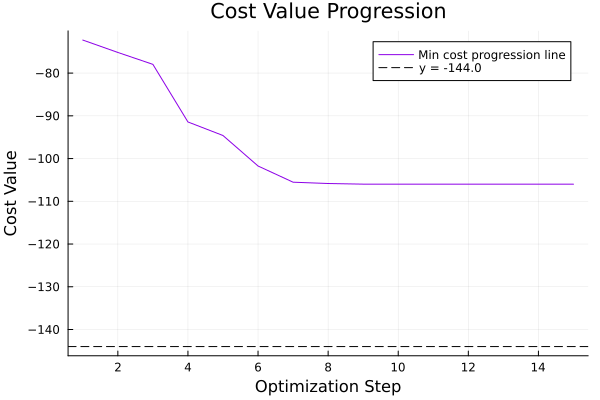

In [36]:
x_vals = 1:length(objective_func_vals)
p1 = plot(x_vals, objective_func_vals, label="Min cost progression line", linecolor="#8d00e7")
hline!(p1, [-max_cut_value], linestyle=:dash, color=:black, label="y = -$(max_cut_value)") # Add horizontal line
xlabel!(p1, "Optimization Step")
ylabel!(p1, "Cost Value")
title!(p1, "Cost Value Progression")
display(p1)

In [37]:
obs = [PauliString(n, :Z, i) for i in 1:n]  # single-qubit Zs

engine = ExpectationEngine(circuit_hex, graph_hex, opt_params_hex, min_abs_coeff, max_weight)
expvals = engine(obs)
bitstring = [ev > 0 ? 0 : 1 for ev in expvals]

max_cut_objective(graph_hex, reverse(bitstring)), max_cut_objective(graph_hex, bitstring)

(106, 106)

### Classical post-processing (bit-flip search)

After obtaining a bitstring from the QAOA circuit, we can improve the solution using a simple classical greedy procedure. Each qubit in the bitstring is flipped sequentially, and the resulting MaxCut value is computed. If flipping the bit increases the cut, the change is retained; otherwise, it is reverted. This process is repeated once for all qubits. Since flipping a bit only affects edges incident to that vertex, the total computational cost of a full sweep is proportional to the number of edges, $O(|E|)$. This post-processing step often increases the cut value without additional quantum resources.

In [38]:
function local_bitflip_search!(x, g)
    n = nv(g)

    # initial cut value
    cut = max_cut_objective(g, x)

    for i in 1:n
        Δ = 0
        xi = x[i]

         # Only edges incident on vertex i matter
        for j in neighbors(g, i)
            if x[j] == xi
                Δ += 1   # edge becomes cut after flip
            else
                Δ -= 1   # edge becomes uncut after flip
            end
        end

        # accept flip if it improves cut
        if Δ > 0
            x[i] = 1 - xi
            cut += Δ
        end
    end

    return cut, x
end

local_bitflip_search! (generic function with 1 method)

In [39]:
new_cut, new_x = local_bitflip_search!(bitstring, graph_hex)
new_cut

144

In [40]:
# Vary truncation parameters
# Vary circuit depth (p)

Random.seed!(42)

obs = [PauliString(n, :Z, i) for i in 1:n]  # single-qubit Zs

coeffs = [1e-1, 1e-2, 1e-4, 1e-8, 1e-10][1:3]
weights = [2., 4, 8, 16, 32][1:3]
n_layers = [1, 2, 4, 6][1:3]
inits = [rand(-π:0.01:π, 2 * p) for p in n_layers]

allcombinations(v...) = vec(collect(Iterators.product(v...)))
combs = allcombinations(coeffs, weights, collect(zip(n_layers, inits)))

struct Expt{T}
    p::Int                 # QAOA depth
    min_abs_coeff::T       # truncation threshold
    max_weight::T        # Pauli weight cutoff
    runtime::T
    opt_params::Vector{T}
    opt_value::T
    bitstring::Vector{T}
    obj_value::T
    new_x::Vector{T}
    new_cut::T
end

;
# Plot runtime / cost vs truncation / depth

In [41]:
using JLD2

In [42]:
history = Dict()

fmt(x; w=10, p=4) = lpad(round(x, digits=p), w)
fmt_int(x; w=6)   = lpad(x, w)

println("=================================================================")
println("  QAOA PP sweep")
println("=================================================================")
println("  min_coeff    max_w     p    runtime(s)   opt_val    cut_val   cut_pp")
println("-----------------------------------------------------------------")
stime = time()
for comb in combs
    min_abs_coeff, max_weight, (p, x0) = comb

    circuit_hex = construct_qaoa_circuit(graph_hex, p)

    cost_hex = CostFunction(
        circuit_hex,
        opsum_hex,
        graph_hex,
        min_abs_coeff,
        max_weight,
    )
    
    function grad_hex!(G, x)
        G .= gradient(cost_hex, x)
    end

    options = Optim.Options(iterations=10, show_trace=false)
    runtime = @elapsed res = optimize(cost_hex, grad_hex!, x0, LBFGS(), options)

    opt_params_hex = Optim.minimizer(res)
    opt_value = Optim.minimum(res)

    engine = ExpectationEngine(circuit_hex, graph_hex, opt_params_hex, min_abs_coeff, max_weight)
    expvals = engine(obs)
    bitstring = [ev > 0 ? 0. : 1. for ev in expvals]

    objval = max_cut_objective(graph_hex, bitstring)
    objval2 = max_cut_objective(graph_hex, reverse(bitstring))
    
    if objval < objval2
        objval = objval2
        bitstring = reverse(bitstring)
    end

    new_cut, new_x = local_bitflip_search!(bitstring, graph_hex)
    
    history[comb] = Expt(p, 
        min_abs_coeff, 
        max_weight, 
        runtime, 
        opt_params_hex, 
        opt_value,
        bitstring,
        objval,
        new_x,
        new_cut
    )

    println(
        fmt(min_abs_coeff, w=10, p=4), "  ",
        fmt_int(max_weight), "  ",
        fmt_int(p), "  ",
        fmt(runtime, w=10, p=3), "  ",
        fmt(opt_value, w=10, p=4), "  ",
        fmt_int(objval), "  ",
        fmt_int(new_cut)
    )
        
end
etime = time()

println("--------------------------------------------------------------")
println("Total duration: ", round(etime - stime, digits=2), " seconds")
println("==============================================================")

save("data.jld2", "data", history)
println("History saved to disk")

  QAOA PP sweep
  min_coeff    max_w     p    runtime(s)   opt_val    cut_val   cut_pp
-----------------------------------------------------------------
       0.1     2.0       1       1.554       -72.0     0.0   143.0
      0.01     2.0       1       0.045       -72.0     0.0   143.0
    0.0001     2.0       1       0.065       -72.0     0.0   143.0
       0.1     4.0       1       0.012       -72.0     0.0   143.0
      0.01     4.0       1       0.059       -72.0     0.0   143.0
    0.0001     4.0       1       0.153       -72.0     0.0   143.0
       0.1     8.0       1       0.012       -72.0     0.0   143.0
      0.01     8.0       1       0.055       -72.0     0.0   143.0
    0.0001     8.0       1       0.098       -72.0     0.0   143.0
       0.1     2.0       2       1.362       -72.0     0.0   143.0
      0.01     2.0       2       0.356      -106.0   106.0   144.0
    0.0001     2.0       2       0.427      -106.0   106.0   144.0
       0.1     4.0       2       0.042     

In [43]:
history = load("data.jld2")["data"];

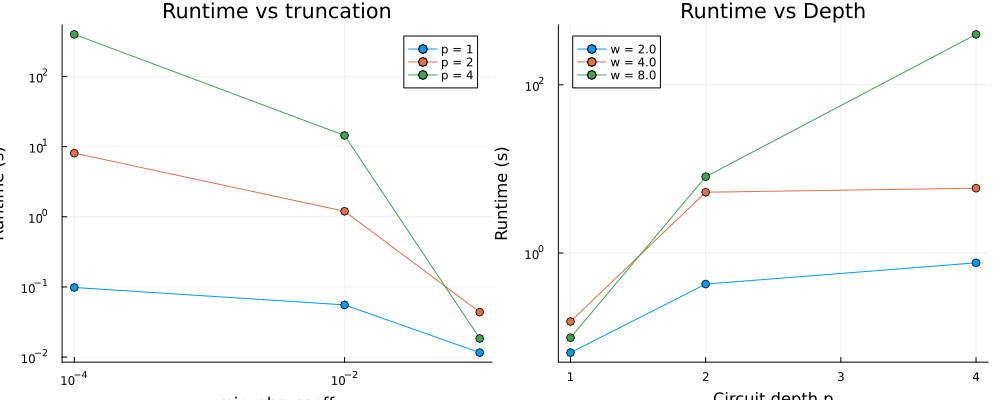

In [44]:
using Plots

expts = collect(values(history))

p_values = sort(unique(e.p for e in expts))

max_weight= 8.0

plt1 = plot(
    xlabel = "min_abs_coeff",
    ylabel = "Runtime (s)",
    xscale = :log10,
    yscale = :log10,
    title  = "Runtime vs truncation",
    legend = :topright,
    marker = :o
)

for p in p_values
    data_p = filter(e -> e.p == p, expts)
    data_p = filter(e -> e.max_weight == max_weight, data_p)
    data_p = sort(data_p, by = e -> e.min_abs_coeff)

    plot!(
        plt1,
        [e.min_abs_coeff for e in data_p],
        [e.runtime for e in data_p],
        label = "p = $p",
        marker=:o
    )
end

trunc_fixed = 1e-4

plt2 = plot(
    xlabel = "Circuit depth p",
    ylabel = "Runtime (s)",
    yscale = :log10,
    title  = "Runtime vs Depth",
    legend = :topleft,
    marker = :o
)

for w in weights
    data_trunc = filter(e -> e.min_abs_coeff == trunc_fixed, expts)
    data_trunc = filter(e -> e.max_weight == w, data_trunc)
    data_trunc = sort(data_trunc, by = e -> e.p)
    
    plot!(
        plt2,
        [e.p for e in data_trunc],
        [e.runtime for e in data_trunc],
        label = "w = $w",
        marker = :o,
    )
end

plot(plt1, plt2, layout = (1,2), size = (1000,400))

## Conclusion

We demonstrated how to use `PauliPropagation` to solve Max-cut problem using QAOA. We started with a toy example and scaled it to larger graph equal to number of qubits of IBM's current devices. By choosing appropriate values of `min_abs_coeff` and `max_weight`, we ensure feasibility of classical simulation of large quantum circuits.